In [14]:
# =============================================
# Model to be visualized
# =============================================


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import activations

# Model configuration
img_width, img_height = 28, 28
batch_size = 250
no_epochs = 10
no_classes = 10
validation_split = 0.2
verbosity = 1

# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

# Reshape data based on channels first / channels last strategy.
# This is dependent on whether you use TF, Theano or CNTK as backend.
# Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
if K.image_data_format() == 'channels_first':
    input_train = input_train.reshape(input_train.shape[0], 1, img_width, img_height)
    input_test = input_test.reshape(input_test.shape[0], 1, img_width, img_height)
    input_shape = (1, img_width, img_height)
else:
    input_train = input_train.reshape(input_train.shape[0], img_width, img_height, 1)
    input_test = input_test.reshape(input_test.shape[0], img_width, img_height, 1)
    input_shape = (img_width, img_height, 1)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

# Convert target vectors to categorical targets
target_train = keras.utils.to_categorical(target_train, no_classes)
target_test = keras.utils.to_categorical(target_test, no_classes)

# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(no_classes, activation='softmax', name='visualized_layer'))

In [15]:
# =============================================
# Compile the model
# =============================================

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [16]:
# =============================================
# Fit the model
# =============================================

model.fit(input_train, target_train,
          batch_size=batch_size,
          epochs=no_epochs,
          verbose=verbosity,
          validation_split=validation_split)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 7s 149us/step - loss: 0.3606 - accuracy: 0.8932 - val_loss: 0.0948 - val_accuracy: 0.9741
Epoch 2/10
48000/48000 [==============================] - 8s 172us/step - loss: 0.0973 - accuracy: 0.9698 - val_loss: 0.0718 - val_accuracy: 0.9784
Epoch 3/10
48000/48000 [==============================] - 15s 306us/step - loss: 0.0703 - accuracy: 0.9779 - val_loss: 0.0496 - val_accuracy: 0.9860
Epoch 4/10
48000/48000 [==============================] - 26s 537us/step - loss: 0.0559 - accuracy: 0.9824 - val_loss: 0.0445 - val_accuracy: 0.9869
Epoch 5/10
48000/48000 [==============================] - 15s 310us/step - loss: 0.0483 - accuracy: 0.9849 - val_loss: 0.0393 - val_accuracy: 0.9889
Epoch 6/10
48000/48000 [==============================] - 15s 306us/step - loss: 0.0398 - accuracy: 0.9871 - val_loss: 0.0394 - val_accuracy: 0.9887
Epoch 7/10
48000/48000 [==============================] - 

In [17]:
# =============================================
# Generate generalization metrics
# =============================================
score = model.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.027812465694203273 / Test accuracy: 0.9901999831199646


In [18]:
# =============================================
# Grad-CAM code
# =============================================

from vis.visualization import visualize_cam, overlay
from vis.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

In [19]:
# Find the index of the to be visualized layer above
layer_index = utils.find_layer_idx(model, 'visualized_layer')

In [20]:
layer_index

8

In [21]:
# Swap softmax with linear
model.layers[layer_index].activation = activations.linear
model = utils.apply_modifications(model)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/tmp/l07x_722.h5'

In [12]:
indices_to_visualize = [ 0, 12, 38, 83, 112, 74, 190 ]

ValueError: Unable to determine penultimate `Conv` or `Pooling` layer for layer_idx: 8

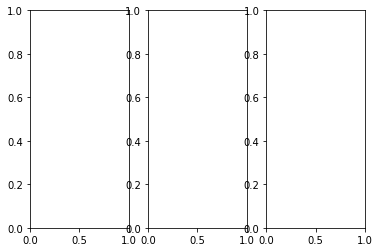

In [13]:
# Visualize
for index_to_visualize in indices_to_visualize:
  # Get input
    input_image = input_test[index_to_visualize]
    input_class = np.argmax(target_test[index_to_visualize])
  # Matplotlib preparations
    fig, axes = plt.subplots(1, 3)
  # Generate visualization
    visualization = visualize_cam(model, layer_index, filter_indices=input_class, seed_input=input_image)
    axes[0].imshow(input_image[..., 0], cmap='gray') 
    axes[0].set_title('Input')
    axes[1].imshow(visualization)
    axes[1].set_title('Grad-CAM')
    heatmap = np.uint8(cm.jet(visualization)[..., :3] * 255)
    original = np.uint8(cm.gray(input_image[..., 0])[..., :3] * 255)
    axes[2].imshow(overlay(heatmap, original))
    axes[2].set_title('Overlay')
    fig.suptitle(f'MNIST target = {input_class}')
    plt.show()